In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)


67 sessions!
67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

In [2]:
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [4]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [5]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [6]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [ ]:
all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)

# seperate detection for central and side arm

In [7]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


reload(pa)
fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

cant format into a dataframe
cant format into a dataframe


In [8]:
# central_arm_bounds_cm = np.array([0,74])
# bin_width = 2.2
# central_arm_bounds_bin = (central_arm_bounds_cm // bin_width).astype(int)

# # check peak in central
# all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)
# pos_key = 'com'
# pos_in_central = all_fields_all_trialtype[pos_key] <= central_arm_bounds_cm[1]


# # check large fraction in central
# width_within_bound=np.minimum(all_fields_all_trialtype['end'],central_arm_bounds_bin[1]) - np.maximum(all_fields_all_trialtype['start'],central_arm_bounds_bin[0])
# width_within_bound.loc[width_within_bound<0] = 0
# width = all_fields_all_trialtype['end'] - all_fields_all_trialtype['start']
# width_within_bound_ratio = width_within_bound / width

# within_central_ratio_thresh = 0.7
# central_field_ma = (width_within_bound_ratio > within_central_ratio_thresh) & pos_in_central#peak_in_central

# all_fields_all_trialtype

# central_fields_all_trialtype  =all_fields_all_trialtype.loc[central_field_ma]

## 1. select left right similar fields
## 2. select central and left right similar fields 
## 3. get splitters (in the process, get the FR for combined trials)
## 4. intersect (central) (non-splitters)
## 5. cpd for central nonsplitters
## 6. concatenate all the change times

In [9]:
import process_central_arm as pca 
reload(pca)

<module 'process_central_arm' from '/mnt/home/szheng/projects/util_code/process_central_arm.py'>

## 1. select left right similar fields

In [16]:
all_fields_all_trialtype

start end com peak    fr_peak    fr_mean
          field_index                                         
0 0.0 3   0              24  40  32   32   2.329971   1.259748
      27  0               1  30  15   15   27.42802  21.757817
      29  0               1  10   5    4   8.114678    7.49303
          1              20  38  29   30  22.516135  14.113698
          2              69  85  76   78  13.805456   9.883463
...                     ...  ..  ..  ...        ...        ...
  1.0 468 0              81  92  86   86   1.415304   1.037694
      474 0              51  62  56   57   1.460745   0.959989
          1              78  88  83   83   1.320478   0.977215
      475 0              24  46  36   40   7.244481   4.140691
      476 0              24  44  33   32   2.977506    1.96505

[762 rows x 6 columns]

In [51]:
task_ind = 0
all_fields = all_fields_all_trialtype.loc[task_ind]
left_right_similar_fields=pca.find_left_right_similar_fields(all_fields)

In [11]:
left_right_similar_fields

,,start,end,com,peak,fr_peak,fr_mean,other_field_index
3,0,24,40,32,32,2.329971,1.259748,0
29,1,20,38,29,30,22.516135,14.113698,1
30,0,1,21,8,6,10.134196,6.402575,0
32,1,62,88,75,81,7.558484,5.853743,3
33,0,16,42,30,29,10.58372,6.379726,0
...,...,...,...,...,...,...,...,...
454,0,30,43,36,37,3.964734,2.631886,0
455,0,1,11,5,6,1.657099,1.311049,0
456,0,30,46,38,40,14.696264,8.662157,0
475,0,24,42,33,36,5.028874,3.177112,0


## 2. select central and left right similar fields 

In [12]:
reload(pca)
central_fields_all_trialtype = pca.get_central_fields(all_fields_all_trialtype.loc[task_ind])

central_lrsim_inds = left_right_similar_fields.index.intersection(central_fields_all_trialtype.loc[0].index)
central_lrsim_fields = left_right_similar_fields.loc[central_lrsim_inds]
central_lrsim_fields

,,start,end,com,peak,fr_peak,fr_mean,other_field_index
29,1,20,38,29,30,22.516135,14.113698,1
30,0,1,21,8,6,10.134196,6.402575,0
35,0,1,6,3,1,5.981159,5.440014,0
37,0,8,16,12,13,7.567584,6.452867,0
48,0,1,17,8,9,22.500053,18.657651,0
...,...,...,...,...,...,...,...,...
398,0,1,18,8,6,8.991645,6.212738,0
428,0,1,11,5,5,6.063917,4.986415,0
443,0,9,23,16,16,13.260107,8.015005,0
448,0,10,27,18,19,10.979548,6.593008,0


## 3. get splitters (in the process, get the FR for combined trials); 4. intersect (central) (non-splitters)

In [21]:
pd.concat(pf_res['avg']['params'],axis=0)

0          1          2          3          4   \
0 0.0 fr_mean 3   0   0.361854   1.660383   0.895757   0.000000   0.469987   
              27  0  14.497671  13.804467  23.114017  20.660537  24.060318   
              29  0   5.357048   8.640619  11.218283   9.660357   6.298226   
                  1   9.346967   7.827861  16.289806  15.501734   6.856234   
                  2   3.397325  16.521741  12.426897   7.661892   9.691956   
...                        ...        ...        ...        ...        ...   
  1.0 std     468 0        NaN   1.584964   2.269803   2.698205   2.787767   
              474 0   2.457588   2.788285   2.434422   2.298644   2.301732   
                  1   1.244095   2.015702   1.756512   2.123467   2.313133   
              475 0   3.932403   3.564496   3.150603   3.840977   3.341930   
              476 0   4.039244   3.238514   3.446693   3.576347   2.797716   

                            5          6          7          8          9   \
0 0.0 fr_mean 3   0   0.000000   0.000000   0.000000   0.000000   1.119021   
              27  0  18.031251  23.890767  18.535940  16.360925  17.245221   
              29  0  16.213038  13.361689  10.567988  11.872521   9.737256   
                  1  12.040284  10.954014  11.643840  12.378693  13.070888   
                  2   6.869698   6.792663   3.437770   5.679589  12.695125   
...                        ...        ...        ...        ...        ...   
  1.0 std     468 0   2.968596        NaN   3.128207   2.818013   2.610830   
              474 0   2.295444   2.463388   2.332549   2.504786   2.925023   
                  1   3.074562   2.640005   2.301063   2.611106   2.697390   
              475 0   2.773330   4.241883   3.277202   2.638185   2.971633   
              476 0   2.523521   2.934306   2.513952   1.839913   2.892434   

                     ...         27         28         29         30  \
0 0.0 fr_mean 3   0  ...   1.727334   2.000357   1.997971   1.820369   
              27  0  ...  17.187522  21.923872  31.692889  19.233423   
              29  0  ...   6.018258   1.828838   0.382512   6.139012   
                  1  ...  16.884102  11.851607  15.581193  11.995440   
                  2  ...  11.359280   6.171581   6.378478   7.828683   
...                  ...        ...        ...        ...        ...   
  1.0 std     468 0  ...   2.517027   2.711096   2.668334        NaN   
              474 0  ...   3.640161   3.692792   2.626668   2.253154   
                  1  ...   2.328035   1.902873   2.287152   2.567727   
              475 0  ...        NaN   2.454297   2.635103   2.357433   
              476 0  ...        NaN        NaN        NaN        NaN   

                            31         32        33        34        35  \
0 0.0 fr_mean 3   0   1.468752   2.298665       NaN       NaN       NaN   
              27  0  23.450917  19.769685       NaN       NaN       NaN   
              29  0   0.095607   0.458614       NaN       NaN       NaN   
                  1  13.127372  14.444362       NaN       NaN       NaN   
                  2   4.355117   4.434275       NaN       NaN       NaN   
...                        ...        ...       ...       ...       ...   
  1.0 std     468 0        NaN   2.738302  2.736809  2.634045  2.558468   
              474 0   2.816255   2.039937  2.528155  2.657729  2.340444   
                  1   2.488245   2.395266  2.422481  2.222669  2.241770   
              475 0   2.606333   2.139743  2.285154  2.427524  2.787999   
              476 0   0.774626        NaN       NaN       NaN       NaN   

                           36  
0 0.0 fr_mean 3   0       NaN  
              27  0       NaN  
              29  0       NaN  
                  1       NaN  
                  2       NaN  
...                       ...  
  1.0 std     468 0  2.340249  
              474 0  2.469786  
                  1  2.789883  
              475 0  3.001777  
              476 0       NaN  

[38

In [22]:
pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),fr_key),:]

0          1          2          3          4   \
0 0.0 fr_peak 3   0   2.726724   6.556670   2.604235   0.000000   1.067943   
              27  0  25.437013  19.987896  34.787907  29.787902  34.664344   
              29  0   6.022801  12.897046  15.636102  10.323528  13.241893   
                  1  25.426426  22.606144  34.580452  33.254925  16.763604   
                  2   6.629354  31.612912  20.228717  11.282127  13.967411   
...                        ...        ...        ...        ...        ...   
  1.0 fr_peak 468 0   0.000000   0.635990   4.900258   5.294146   4.109898   
              474 0   2.578507   0.938446   0.501888   1.350737   1.853118   
                  1   0.844382   0.855200   2.909927   2.851029   1.925100   
              475 0  26.244570  25.859864  44.752176  13.789712  25.009117   
              476 0  28.862165  24.834263  19.290711   7.409706  10.001094   

                            5          6          7          8          9   \
0 0.0 fr_peak 3   0   0.000000   0.000000   0.000000   0.000000   2.211295   
              27  0  23.649173  41.734470  22.899713  26.880126  23.878131   
              29  0  19.403862  14.534115  11.478309  13.216431  10.790737   
                  1  20.502070  16.867060  24.613671  22.536541  25.753082   
                  2  15.050778  12.411826   6.567764  14.604429  24.033733   
...                        ...        ...        ...        ...        ...   
  1.0 fr_peak 468 0   3.178009   0.000000   9.173229   4.376850   1.979321   
              474 0   0.415409   1.815873   3.276048   3.566141   3.584286   
                  1   4.617333   1.495926   2.503327   1.751369   1.798257   
              475 0  25.543538  26.494469  25.258902  28.156544  15.233679   
              476 0   1.641760  21.935124  18.903340   5.864690   2.031157   

                     ...         27         28         29         30  \
0 0.0 fr_peak 3   0  ...   3.833263   4.230902   4.049848   4.615942   
              27  0  ...  24.404045  29.757728  39.647722  25.301658   
              29  0  ...   6.943250   2.212766   0.570941   6.808122   
                  1  ...  33.338906  22.258196  30.373815  22.194960   
                  2  ...  17.599709  13.381450  14.687499  13.127737   
...                  ...        ...        ...        ...        ...   
  1.0 fr_peak 468 0  ...   1.274179   1.954046   1.706892   0.000000   
              474 0  ...   1.043484   1.580398   3.949794   1.940675   
                  1  ...   0.637089   0.668480   2.443957   1.692557   
              475 0  ...   0.000000   1.631331   1.749056   1.219948   
              476 0  ...   0.000000   0.000000   0.000000   0.000000   

                            31         32        33        34        35  \
0 0.0 fr_peak 3   0   3.480658   4.288309       NaN       NaN       NaN   
              27  0  32.204385  28.548296       NaN       NaN       NaN   
              29  0   0.479565   0.561037       NaN       NaN       NaN   
                  1  28.392271  24.007206       NaN       NaN       NaN   
                  2   7.586079  11.648362       NaN       NaN       NaN   
...                        ...        ...       ...       ...       ...   
  1.0 fr_peak 468 0   0.000000   0.670035  2.733285  7.632860  2.186154   
              474 0   2.970909   2.869427  1.943375  2.042111  1.660386   
                  1   2.406986   1.586688  2.740569  1.852721  1.817434   
              475 0   2.645331   2.751157  4.071890  3.015947  2.097148   
              476 0   0.121764   0.000000  0.000000  0.000000  0.000000   

                           36  
0 0.0 fr_peak 3   0       NaN  
              27  0       NaN  
              29  0       NaN  
                  1       NaN  
                  2       NaN  
...                       ...  
  1.0 fr_peak 468 0  1.039836  
              474 0  1.166415  
                  1  1.441398  
              475 0  7.561338  
              476 0  0.000000  

[76

In [61]:
fr_key = 'fr_peak'
pf_fr = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),fr_key),:]
index=pf_fr.index.droplevel(2)
pf_fr.index=index
pf_fr = pf_fr.loc[task_ind]

pf_fr_trialtype_combined = pca.combine_left_right_simlar_fields(pf_fr,selected_fields=central_lrsim_fields, index_within_to_trial_index_df=index_within_to_trial_index_df.loc[task_ind])
lr_fr_diff = pca.get_left_right_intensity_difference(pf_fr_trialtype_combined, index_within_to_trial_index_df.loc[task_ind])
alpha = 0.05
nonsplitter_inds = lr_fr_diff.loc[lr_fr_diff['pval'] >= alpha].index
splitter_inds = lr_fr_diff.loc[lr_fr_diff['pval'] < alpha].index

splitter_fields = central_lrsim_fields.loc[splitter_inds] 
nonsplitter_fields = central_lrsim_fields.loc[nonsplitter_inds] # this will be NEEDED!

pf_fr_trialtype_combined_nonsplitter = pf_fr_trialtype_combined.loc[nonsplitter_inds]
pf_fr_trialtype_combined_splitter = pf_fr_trialtype_combined.loc[splitter_inds]


In [13]:
def mean_error_plot(df,xs=None,ci_scale=1.96,axis=0,fig=None,ax=None,alpha=0.5,label=None):
    dfmean = df.mean(axis=axis)
    error = df.sem(axis=axis) * ci_scale
    dfup,dflow = dfmean + error, dfmean - error
    if ax is None:
        fig,ax=plt.subplots()
    if xs is None:
        xs = df.columns
        
    ax.fill_between(xs,dflow,dfup,alpha=alpha)
    ax.plot(xs,dfmean.values,label=label)
    return fig,ax
    

[Text(0.5, 0, 'Trial'), Text(0, 0.5, 'FR'), Text(0.5, 1.0, 'average fr_peak')]

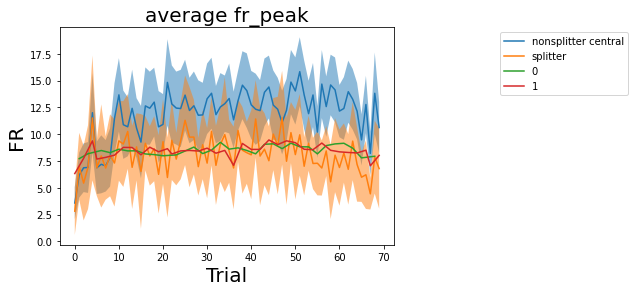

In [123]:
fig,ax=mean_error_plot(pf_fr_trialtype_combined_nonsplitter,ci_scale=1.96,axis=0,fig=None,ax=None,label='nonsplitter central')
fig,ax=mean_error_plot(pf_fr_trialtype_combined_splitter,ci_scale=1.96,axis=0,fig=fig,ax=ax,label='splitter')
ax.plot(index_within_to_trial_index_df.loc[task_ind,0].values,pf_fr.loc[0].dropna(axis=1).mean(axis=0),label='0')
ax.plot(index_within_to_trial_index_df.loc[task_ind,1].values,pf_fr.loc[1].dropna(axis=1).mean(axis=0),label='1')
# ax.legend(['nonsplitter central','splitter','0','1'],bbox_to_anchor=(1.3,1))
ax.legend(bbox_to_anchor=(1.3,1))
ax.set(xlabel='Trial',ylabel='FR',title=f'average {fr_key}')


## 5. cpd for central nonsplitters

In [66]:
# cpa.get_change_points_all_fields(X_restacked_df_d,peak_inds_df_d=None,pen=0.2,model_type='pelt',cost='l2')

X_central = pf_fr_trialtype_combined_nonsplitter / pf_fr_trialtype_combined_nonsplitter.max(axis=1).values[:,None]
X_central_pwc,cpts = cpa.predict_from_cpts_wrapper_allrows(X_central,pen=0.3,min_size=1)
# switch_on_central, switch_off_central, changes_df_central = cpa.detect_switch_pwc(X_central_pwc, switch_magnitude=0.,low_thresh=1.,high_thresh=0.)
switch_on_central, switch_off_central, changes_df_central = cpa.detect_switch_pwc(X_central_pwc, switch_magnitude=0.4,low_thresh=1.,high_thresh=0.)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 6. concatenate all the change times

In [68]:
reload(pca)
changes_df_both_trialtype = switch_res['avg']['changes_df'].loc[task_ind,slice(None),0.3,'switch_magnitude',0.4]
changes_df_combined,changes_df_combined_d = pca.combine_changes_df_side_central(changes_df_central,changes_df_both_trialtype,nonsplitter_fields,index_within_to_trial_index_df.loc[task_ind])



In [ ]:
# changes_df_onett = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3].dropna(axis=1).droplevel(level=(0,1))
# changes_df_both_tt = switch_res['avg']['changes_df'].loc[task_ind,slice(None),0.3,'switch_magnitude',0.4]


In [69]:
index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)
trial_pos_info = pca.get_trial_pos_info(spk_beh_df,speed_thresh=0)
pos_to_time_func_per_trial = pca.get_pos_to_time_func_per_trial(trial_pos_info)
# all_sw_times_d = {}
# for tt_ind in [0,1]:
#     changes_df_onett = changes_df_both_tt.loc[tt_ind].dropna(axis=1)
#     field_loc = pca.get_field_loc_per_trial(pf_res, task_ind,tt_ind,loc_key='peak')
#     all_sw_times_d[tt_ind]=pca.get_all_switch_times(pos_to_time_func_per_trial,field_loc,changes_df_onett,index_within_to_trial_index_df,task_ind=0,tt_ind=tt_ind)



In [70]:
loc_key = 'peak'
pf_loc_both_tt = pd.concat(pf_res['avg']['params'],axis=0).loc[task_ind,slice(None),loc_key] # consider move this outside of the function


reload(pca)
pf_loc_combined = pca.combine_field_loc(pf_res,nonsplitter_fields,index_within_to_trial_index_df,loc_key='peak',task_ind = 0)

reload(pca)
all_sw_times_v_combined = pca.get_all_switch_times_combined(pos_to_time_func_per_trial,pf_loc_combined,changes_df_combined)

In [59]:
reload(pca)
cdf,pmf,bin_edges = pca.get_sw_times_pairwise_diff(all_sw_times_v_combined,bins=100)

In [193]:
all_sw_times_v_combined

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,29,1,7893.902900,36.778932,21.0,1,1.0
1,both,140,0,7893.386117,7.336045,9.0,1,1.0
2,both,455,0,7893.252750,1.939159,7.0,1,1.0
0,both,168,0,7918.842533,36.627722,23.0,2,-1.0
1,both,386,1,7918.492467,29.929168,18.0,2,1.0
...,...,...,...,...,...,...,...,...
13,1,311,1,9989.965667,21.281060,63.0,69,-1.0
14,1,378,1,9998.351117,11.046759,89.0,69,1.0
15,1,424,0,9988.131867,2.869145,51.0,69,1.0
16,1,430,1,9998.151067,7.238519,87.0,69,1.0


In [182]:
changes_df_combined

0    1    2    3    4    5    6    7    8    9   ...   60   61  \
both 29  1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     35  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  ...  0.0  0.0   
     37  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     48  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     54  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0 -1.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1    468 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  NaN  0.0  ...  0.0  NaN   
     474 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  NaN  0.0  ...  0.0  NaN   
         1  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  NaN  0.0  ...  0.0  NaN   
     475 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  NaN  0.0  ...  0.0  NaN   
     476 0  0.0  NaN  0.0  NaN  0.0 -1.0  NaN  0.0  NaN  0.0  ...  0.0  NaN   

             62   63   64   65   66   67   68   69  
both 29  1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     35  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     37  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     48  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
     54  0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
1    468 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  
     474 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  
         1  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  
     475 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  
     476 0  0.0  NaN  0.0  NaN  0.0  0.0  NaN  0.0  

[709 rows x 70 columns]

In [181]:
all_sw_times_v_combined

,trialtype,uid,field_index,time,v,field_pos,trial_index
0,both,29,1,7893.902900,36.778932,21.0,1
1,both,140,0,7893.386117,7.336045,9.0,1
2,both,455,0,7893.252750,1.939159,7.0,1
0,both,168,0,7918.842533,36.627722,23.0,2
1,both,386,1,7918.492467,29.929168,18.0,2
...,...,...,...,...,...,...,...
13,1,311,1,9989.965667,21.281060,63.0,69
14,1,378,1,9998.351117,11.046759,89.0,69
15,1,424,0,9988.131867,2.869145,51.0,69
16,1,430,1,9998.151067,7.238519,87.0,69


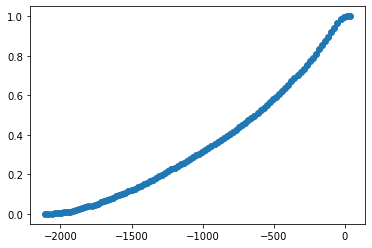

In [327]:
plt.plot(bin_edges[:-1],cdf,marker='o')

# aggregating 1-6

In [10]:
import change_point_analysis_central_arm_seperate as cpacas

In [51]:
reload(cpacas)

<module 'change_point_analysis_central_arm_seperate' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis_central_arm_seperate.py'>

In [39]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [52]:
%%time
cpacas.sweep_test_coswitch_wrapper(data_dir_full,
                                pf_res_save_fn='place_field_avg_and_trial_vthresh.p',
                                pf_shuffle_fn = 'fr_map_null_trialtype_vthresh.p',
                                speed_key='v',
                                )

cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---
INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 5.02 s, sys: 2.46 s, total: 7.48 s
Wall time: 11 s


In [11]:
reload(pca)
reload(cpacas)

task_ind = 0
all_fields = all_fields_all_trialtype.loc[task_ind]

fr_key = 'fr_peak'
pf_fr = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),fr_key),:]
index=pf_fr.index.droplevel(2)
pf_fr.index=index
pf_fr = pf_fr.loc[task_ind]

changes_df_both_trialtype = switch_res['avg']['changes_df'].loc[task_ind,slice(None),0.3,'switch_magnitude',0.4]

res = cpacas.switch_detection_combined(pf_res, all_fields, pf_fr, index_within_to_trial_index_df, spk_beh_df, changes_df_both_trialtype=changes_df_both_trialtype,task_ind=0)



INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
cpacas.sweep_test_coswitch(all_sw_times_v_combined,all_sw_times_v_combined_shuffle_l,all_fields_times_v,edges,onoff=1,p_thresh=0.05,ci=0.95,do_ratio=False,exclude_self=False,normalize_by_window=False)




In [20]:
df = res['all_sw_times_v_combined']

In [25]:
reload(cpacas)
cpacas.count_diff_within(df,time_diff_thresh_up=30,time_diff_thresh_low=0,exclude_self=False)

11189

In [24]:
reload(cpacas)
cpacas.count_diff_within(df,time_diff_thresh_up=30,time_diff_thresh_low=0,exclude_self=True)

11152

In [29]:
pf_res['avg']['params'][0,0]

0          1          2          3          4   \
fr_mean 3   0   0.361854   1.660383   0.895757   0.000000   0.469987   
        27  0  14.497671  13.804467  23.114017  20.660537  24.060318   
        29  0   5.357048   8.640619  11.218283   9.660357   6.298226   
            1   9.346967   7.827861  16.289806  15.501734   6.856234   
            2   3.397325  16.521741  12.426897   7.661892   9.691956   
...                  ...        ...        ...        ...        ...   
std     463 1   2.160638   2.005217   2.143361   1.892196   2.105187   
        465 0   0.596658   2.923143        NaN   2.424171        NaN   
        475 0   3.162053   2.819765   3.167099   2.886244   2.891080   
        476 0   2.029287   2.425701   2.438282   2.793227   2.644458   
        480 0   3.035396   3.010349   3.380375   4.669752   3.790325   

                      5          6          7          8          9   ...  \
fr_mean 3   0   0.000000   0.000000   0.000000   0.000000   1.119021  ...   
        27  0  18.031251  23.890767  18.535940  16.360925  17.245221  ...   
        29  0  16.213038  13.361689  10.567988  11.872521   9.737256  ...   
            1  12.040284  10.954014  11.643840  12.378693  13.070888  ...   
            2   6.869698   6.792663   3.437770   5.679589  12.695125  ...   
...                  ...        ...        ...        ...        ...  ...   
std     463 1   1.879038   1.920407   1.376514   2.036755   2.412102  ...   
        465 0   2.299744   2.725661        NaN   4.594505   2.573303  ...   
        475 0   2.767675   2.772430   2.718800   3.009274   3.048366  ...   
        476 0   2.360428   1.882534   2.522186   2.637506   2.858958  ...   
        480 0   3.015795   3.643526   3.476285   3.556263   4.469704  ...   

                      23         24         25         26         27  \
fr_mean 3   0   1.073219   1.116206   1.424825   2.067054   1.727334   
        27  0  18.785730  26.555358  22.520142  27.910965  17.187522   
        29  0   7.317475   0.092530   3.476891   1.884900   6.018258   
            1  17.828346  17.131333  19.303846  16.753613  16.884102   
            2  14.163162  11.938834   9.940098  15.245129  11.359280   
...                  ...        ...        ...        ...        ...   
std     463 1   1.618533   2.002209   2.042708   2.046559   2.250909   
        465 0   2.469821        NaN   2.363817   1.902023   2.441664   
        475 0   2.727850   2.766335   2.761957   2.818102   2.702356   
        476 0        NaN        NaN        NaN        NaN        NaN   
        480 0   3.328041   4.009034   3.788421   3.941654   3.657306   

                      28         29         30         31         32  
fr_mean 3   0   2.000357   1.997971   1.820369   1.468752   2.298665  
        27  0  21.923872  31.692889  19.233423  23.450917  19.769685  
        29  0   1.828838   0.382512   6.139012   0.095607   0.458614  
            1  11.851607  15.581193  11.995440  13.127372  14.444362  
            2   6.171581   6.378478   7.828683   4.355117   4.434275  
...                  ...        ...        ...        ...        ...  
std     463 1   1.908929   2.089821        NaN   2.039449   2.091486  
        465 0        NaN   2.401132        NaN   5.751352        NaN  
        475 0   3.033483   2.126476   2.929911   3.121934   3.176648  
        476 0        NaN        NaN        NaN        NaN        NaN  
        480 0   3.068466   3.371639   3.159068   4.487240   4.790587  

[1930 rows x 33 columns]

In [55]:
pos_to_time_func_per_trial = res['pos_to_time_func_per_trial']
pf_loc_combined= res['pf_loc_combined']


reload(pca)
all_fields_times_v =pca.get_all_place_field_times_combined(pos_to_time_func_per_trial,pf_loc_combined)

In [80]:
count=cpacas.count_diff_within(df,time_diff_thresh_up=10 ,time_diff_thresh_low=0,exclude_self=True)



In [81]:
count

4107

In [82]:
count=cpacas.count_diff_within(all_field_times_v,time_diff_thresh_up=10 ,time_diff_thresh_low=0,exclude_self=True)



In [83]:
count

3640905

In [85]:
np.sqrt(4000 / 3640905)

0.03314555703284639

In [71]:
(switch_res['avg']['changes_df'].loc[0,1,0.3]==1).mean()

/tmp/ipykernel_103703/3466480191.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  (switch_res['avg']['changes_df'].loc[0,1,0.3]==1).mean()


0     0.000000
1     0.013298
2     0.023936
3     0.015957
4     0.021277
5     0.055851
6     0.034574
7     0.037234
8     0.029255
9     0.023936
10    0.010638
11    0.018617
12    0.023936
13    0.039894
14    0.023936
15    0.013298
16    0.010638
17    0.013298
18    0.007979
19    0.010638
20    0.029255
21    0.018617
22    0.013298
23    0.010638
24    0.015957
25    0.002660
26    0.002660
27    0.002660
28    0.007979
29    0.010638
30    0.015957
31    0.010638
32    0.010638
33    0.002660
34    0.005319
35    0.018617
36    0.037234
dtype: float64

In [42]:
res['all_sw_times_v_combined']

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,29,1,7893.902900,36.778932,21.0,1,1.0
1,both,140,0,7893.386117,7.336045,9.0,1,1.0
2,both,455,0,7893.252750,1.939159,7.0,1,1.0
0,both,168,0,7918.842533,36.627722,23.0,2,-1.0
1,both,386,1,7918.492467,29.929168,18.0,2,1.0
...,...,...,...,...,...,...,...,...
13,1,311,1,9989.965667,21.281060,63.0,69,-1.0
14,1,378,1,9998.351117,11.046759,89.0,69,1.0
15,1,424,0,9988.131867,2.869145,51.0,69,1.0
16,1,430,1,9998.151067,7.238519,87.0,69,1.0


# 7. shuffle test

In [73]:
reload(pca)
changes_df_combined_shuffle_l = pca.gen_circular_shuffle_changes_df_combined(changes_df_combined_d,index_within_to_trial_index_df.loc[task_ind],nrepeats=1000)


In [81]:
bins = np.array([-2500,-1000,-500,-250,-100,-50,0])
# bins = 5
all_sw_times_v_combined_on = all_sw_times_v_combined.loc[all_sw_times_v_combined['switch']==1]
all_sw_times_v_combined_off = all_sw_times_v_combined.loc[all_sw_times_v_combined['switch']==-1]
cdf,pmf,bin_edges = pca.get_sw_times_pairwise_diff(all_sw_times_v_combined_on,bins=bins)


In [201]:
%%time
all_sw_times_v_combined_shuffle_l = []
cdf_shuffle_l = []
pmf_shuffle_l = []
for cdcs in changes_df_combined_shuffle_l[:500]:
    all_sw_times_v_combined_shuffle = pca.get_all_switch_times_combined(pos_to_time_func_per_trial,pf_loc_combined,cdcs)
    
    all_sw_times_v_combined_shuffle_on = all_sw_times_v_combined_shuffle.loc[all_sw_times_v_combined_shuffle['switch']==1]
    all_sw_times_v_combined_shuffle_off = all_sw_times_v_combined_shuffle.loc[all_sw_times_v_combined_shuffle['switch']==-1]
    
    all_sw_times_v_combined_shuffle_l.append(all_sw_times_v_combined_shuffle)
    # only for on for now
    cdf,pmf,bin_edges = pca.get_sw_times_pairwise_diff(all_sw_times_v_combined_shuffle_on,bins=bin_edges)
    pmf_shuffle_l.append(pmf)
    cdf_shuffle_l.append(cdf)
cdf_shuffle_l = pd.DataFrame(cdf_shuffle_l)
pmf_shuffle_l = pd.DataFrame(pmf_shuffle_l)

CPU times: user 2min 15s, sys: 338 ms, total: 2min 15s
Wall time: 2min 15s


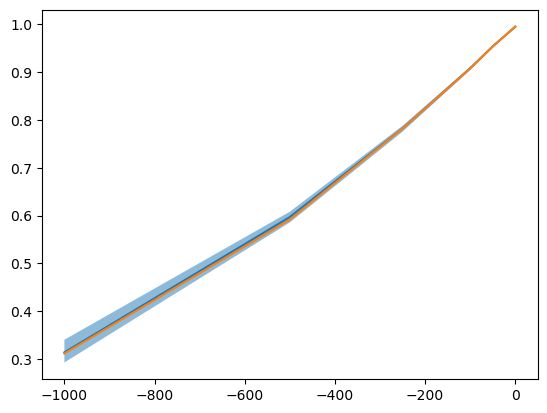

In [202]:
reload(ph)
fig,ax=ph.mean_error_plot(cdf_shuffle_l,xs=bin_edges[1:],sem=False)
ax.plot(bin_edges[1:],cdf)


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

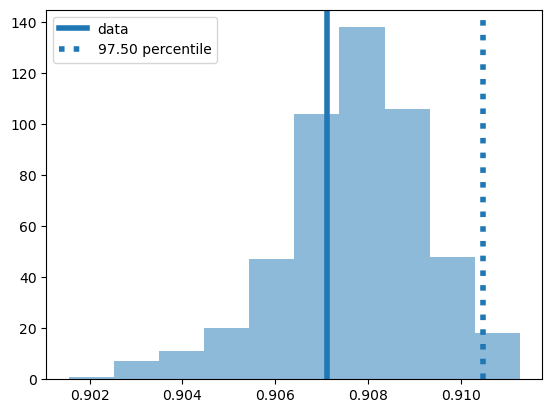

In [212]:
qq = 3
ph.plot_shuffle_data_dist_with_thresh(cdf_shuffle_l[qq],cdf[qq],alpha=0.025,fig=None,ax=None,lw=4)

## confirm with old method. why not significant??

In [213]:
reload(pca)
changes_df_combined_shuffle_l = pca.gen_circular_shuffle_changes_df_combined(changes_df_combined_d,index_within_to_trial_index_df.loc[task_ind],nrepeats=1000)


In [218]:
shared_on_shuffle =[cpa.get_shared_onoff(cdcs)[3] for cdcs in changes_df_combined_shuffle_l]

In [220]:
shared_on_data = cpa.get_shared_onoff(changes_df_combined)[3]

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

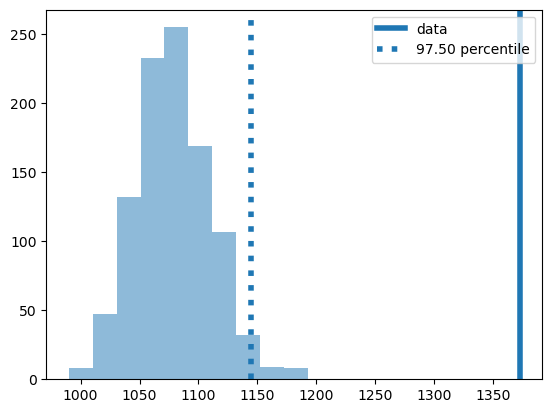

In [221]:
ph.plot_shuffle_data_dist_with_thresh(shared_on_shuffle,shared_on_data,alpha=0.025,fig=None,ax=None,lw=4)



## if use trial window size, what's the statistics for the co switching count


In [232]:
diff = np.abs(all_sw_times_v_combined_on['time'].values[:,None]-all_sw_times_v_combined_on['time'].values[None,:])

(diff[np.triu_indices(diff.shape[0],1)] < 30).sum()


3324

In [241]:
c_data=count_diff_within(all_sw_times_v_combined_on)

In [74]:
def count_diff_within(df,time_diff_thresh_up=30,time_diff_thresh_low=0):
    diff = np.abs(df['time'].values[:,None] - df['time'].values[None,:])
    diff_flat = diff[np.triu_indices(diff.shape[0],1)]
    count = ((diff_flat < time_diff_thresh_up) & (diff_flat > time_diff_thresh_low)).sum()
    return count

def count_diff_within_shuffle(all_sw_times_v_combined_shuffle_l,onoff=1,thresh_up=30,thresh_low=0):
    c_l = []
    for ast in all_sw_times_v_combined_shuffle_l:
        ast_on = ast.loc[ast['switch']==onoff]
        c = count_diff_within(ast_on,time_diff_thresh_up=thresh_up,time_diff_thresh_low=thresh_low)
        c_l.append(c)
    return np.array(c_l)
    
        


In [75]:
edges = [0,10,30,60,100,200,300,400,500,600]

In [82]:
%%time
c_l_d = {}
c_data_d = {}
for low, up in zip(edges[:-1],edges[1:]):
    c_l = count_diff_within_shuffle(all_sw_times_v_combined_shuffle_l,onoff=1,thresh_up=up,thresh_low=low)
    c_data=count_diff_within(all_sw_times_v_combined_on,time_diff_thresh_up=up,time_diff_thresh_low=low)
    c_l_d[(low,up)] = c_l
    c_data_d[(low,up)] = c_data
    


CPU times: user 48.9 ms, sys: 7.96 ms, total: 56.9 ms
Wall time: 55.7 ms


In [97]:
changes_df_combined_d = res['changes_df_combined_d']
all_sw_times_v_combined = res['all_sw_times_v_combined']
all_fields_times_v = res['all_fields_times_v']

In [137]:
%%time
edges = np.linspace(0,600,60).round(0)
# edges = np.logspace(-1,np.log(600),10,base=np.exp(1)).round(0)
reload(cpacas)
all_sw_times_v_combined_shuffle_l = cpacas.shuffle_changes_df_combined_get_sw_times_v_combined_shuffle(changes_df_combined_d,index_within_to_trial_index_df,pos_to_time_func_per_trial,pf_loc_combined,nrepeats=5,task_ind=0)
# test_res_df_on,c_shuffle_d, rate_shuffle_d = cpacas.sweep_test_coswitch(all_sw_times_v_combined,all_sw_times_v_combined_shuffle_l,edges,all_fields_times_v=all_fields_times_v,onoff=1)
# test_res_df_off,c_shuffle_d, rate_shuffle_d = cpacas.sweep_test_coswitch(all_sw_times_v_combined,all_sw_times_v_combined_shuffle_l,all_fields_times_v,edges,onoff=-1)

test_res_df_on,c_shuffle_d = cpacas.sweep_test_coswitch(all_sw_times_v_combined,all_sw_times_v_combined_shuffle_l,edges,all_fields_times_v=all_fields_times_v,onoff=1)


CPU times: user 1min 14s, sys: 12.4 s, total: 1min 27s
Wall time: 1min 27s


In [138]:
test_res_df_on=test_res_df_on.set_index('window_median')

<AxesSubplot:xlabel='window_median'>

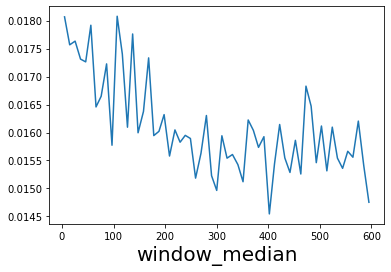

In [139]:
%matplotlib inline
np.sqrt(test_res_df_on['count'] /test_res_df_on['baseline']).plot()

<AxesSubplot:xlabel='window_median'>

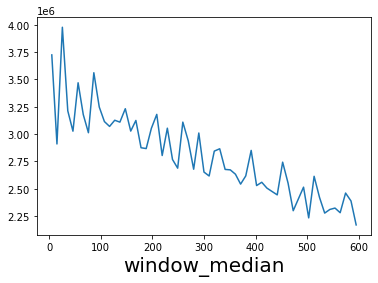

In [140]:
test_res_df_on['baseline'].plot()

In [111]:
all_fields_time_diff = cpacas.get_diff_flatten(all_fields_times_v,exclude_self=False)
all_fields_time_diff_excld = cpacas.get_diff_flatten(all_fields_times_v,exclude_self=True)

In [125]:
reload(cpacas)
cpacas.count_diff_within(all_fields_times_v,diff_flat=all_fields_time_diff_excld,exclude_self=True,time_diff_thresh_low=0,time_diff_thresh_up=6)

(2464580,
 array([ 0.76686667,  0.86688333,  6.21823333, ..., 12.4198    ,
        13.58676667,  1.16696667]))

In [126]:
edges

array([  0.,  10.,  20.,  31.,  41.,  51.,  61.,  71.,  81.,  92., 102.,
       112., 122., 132., 142., 153., 163., 173., 183., 193., 203., 214.,
       224., 234., 244., 254., 264., 275., 285., 295., 305., 315., 325.,
       336., 346., 356., 366., 376., 386., 397., 407., 417., 427., 437.,
       447., 458., 468., 478., 488., 498., 508., 519., 529., 539., 549.,
       559., 569., 580., 590., 600.])

(array([10275590.,  9804824.,  9454966.,  9495302.,  9260138.,  9076854.,
         8945242.,  8651545.,  8546419.,  8317955.,  8193294.,  8017258.,
         7734306.,  7648014.,  7471742.,  7394652.,  7154729.,  7069114.,
         6972776.,  6808415.]),
 array([  0.        ,  29.99974533,  59.99949067,  89.999236  ,
        119.99898133, 149.99872667, 179.998472  , 209.99821733,
        239.99796267, 269.997708  , 299.99745333, 329.99719867,
        359.996944  , 389.99668933, 419.99643467, 449.99618   ,
        479.99592533, 509.99567067, 539.995416  , 569.99516133,
        599.99490667]),
 <BarContainer object of 20 artists>)

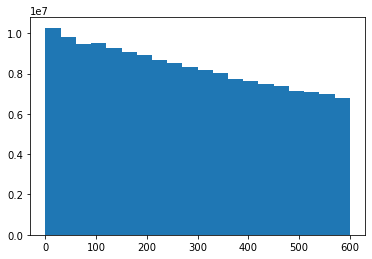

In [132]:
plt.hist(all_fields_time_diff[all_fields_time_diff<=600],bins=20)

(array([2464580., 1890479., 1699448., 1847419., 2344625., 2001314.,
        1893196., 1770744., 1949832., 2149584.]),
 array([ 0.     ,  5.99985, 11.9997 , 17.99955, 23.9994 , 29.99925,
        35.9991 , 41.99895, 47.9988 , 53.99865, 59.9985 ]),
 <BarContainer object of 10 artists>)

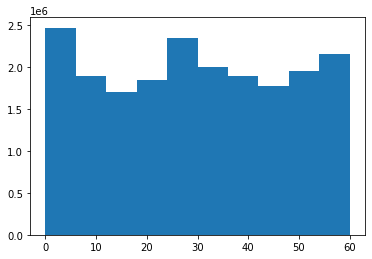

In [120]:
plt.hist(all_fields_time_diff_excld[all_fields_time_diff_excld<=60])

In [119]:
((all_fields_time_diff>=0)&(all_fields_time_diff<=6)).sum()

2467789

In [181]:
def plot_rate_vs_time_shuffle_test_res(test_res_df,fig=None,ax=None,**kwargs):
    '''
    test_res_df:
    '''
    if ax is None:
        fig,ax=plt.subplots()
    
    xs = test_res_df['window_median']
    ax.fill_between(xs,test_res_df['rate_ci_low'],test_res_df['rate_ci_up'],alpha=alpha,label='shuffle ci')
    ax.plot(xs,test_res_df['rate_p_thresh'],linestyle=':',label='significant threshold')
    ax.plot(xs,test_res_df['rate'],label='data')
    ax.legend()
    ax.set_xlabel('Window of co-switch')
    ax.set_ylabel('Rate of co-switch (per sec)')
    
    return fig,ax

In [188]:
all_sw_times_v_combined

,trialtype,uid,field_index,time,v,field_pos,trial_index,switch
0,both,29,1,7893.902900,36.778932,21.0,1,1.0
1,both,140,0,7893.386117,7.336045,9.0,1,1.0
2,both,455,0,7893.252750,1.939159,7.0,1,1.0
0,both,168,0,7918.842533,36.627722,23.0,2,-1.0
1,both,386,1,7918.492467,29.929168,18.0,2,1.0
...,...,...,...,...,...,...,...,...
13,1,311,1,9989.965667,21.281060,63.0,69,-1.0
14,1,378,1,9998.351117,11.046759,89.0,69,1.0
15,1,424,0,9988.131867,2.869145,51.0,69,1.0
16,1,430,1,9998.151067,7.238519,87.0,69,1.0


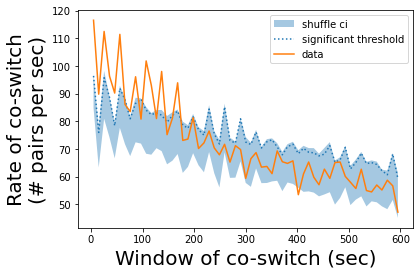

In [184]:
reload(cpp)
fig,ax=cpp.plot_rate_vs_time_shuffle_test_res(test_res_df_on,time_key='window_median',fig=None,ax=None)

In [102]:
pd.DataFrame(rate_shuffle_d)

,0.0,10.0,20.0,31.0,41.0,51.0,61.0,71.0,81.0,92.0,...,498.0,508.0,519.0,529.0,539.0,549.0,559.0,569.0,580.0,590.0
,10.0,20.0,31.0,41.0,51.0,61.0,71.0,81.0,92.0,102.0,...,508.0,519.0,529.0,539.0,549.0,559.0,569.0,580.0,590.0,600.0
0,94.5,73.2,94.272727,83.2,78.0,92.3,80.6,80.2,87.000000,87.4,...,48.5,52.636364,47.7,46.7,48.6,47.5,47.9,52.454545,52.9,48.5
1,87.5,71.6,85.181818,81.1,77.4,85.2,75.5,77.0,77.454545,73.0,...,60.9,57.909091,59.9,57.1,59.9,61.0,60.3,52.909091,66.1,52.3


<AxesSubplot:>

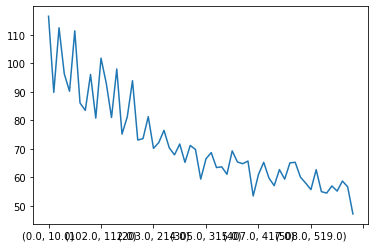

In [100]:
pd.Series(rate_data_d).plot()

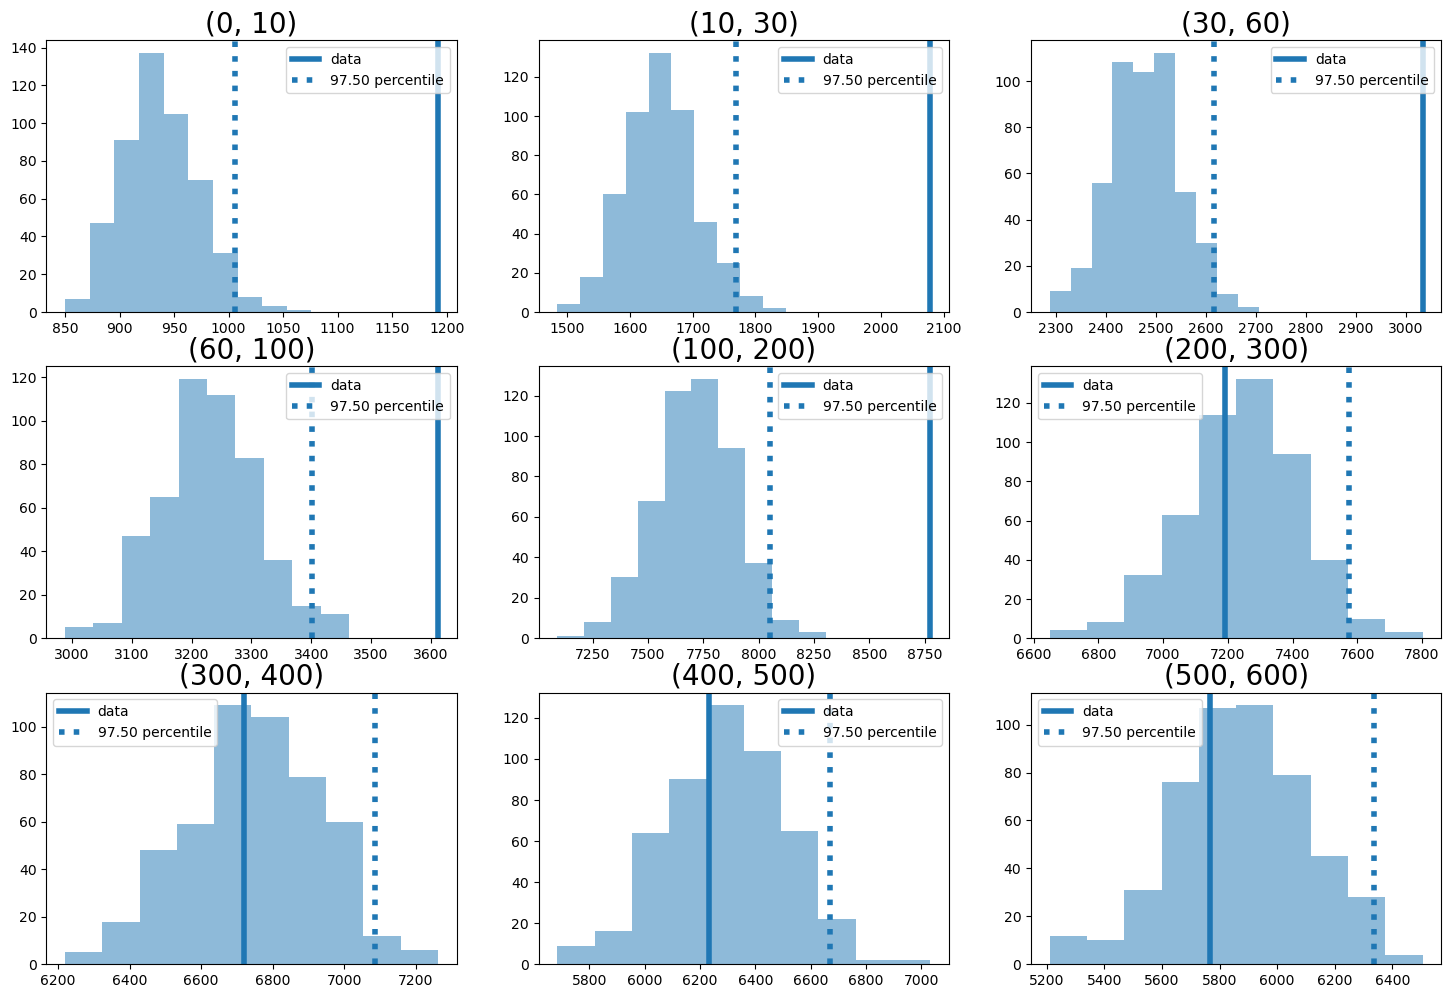

In [284]:
# plot
nplots = len(c_data_d)
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
for ii,k in enumerate(c_data_d.keys()):
    ax = axs.ravel()[ii]
    c_l = c_l_d[k]
    c_data = c_data_d[k]
    fig,ax = ph.plot_shuffle_data_dist_with_thresh(c_l,c_data,alpha=0.025,lw=4,fig=fig,ax=ax)
    ax.set_title(k)
    

In [276]:
# c_l = []
# thresh_up = 400
# thresh_low = 300

# for ast in all_sw_times_v_combined_shuffle_l[:200]:
#     ast_on = ast.loc[ast['switch']==1]
#     c = count_diff_within(ast_on,time_diff_thresh_up=thresh_up,time_diff_thresh_low=thresh_low)
#     c_l.append(c)
    
# c_data=count_diff_within(all_sw_times_v_combined_on,time_diff_thresh_up=thresh_up,time_diff_thresh_low=thresh_low)


(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

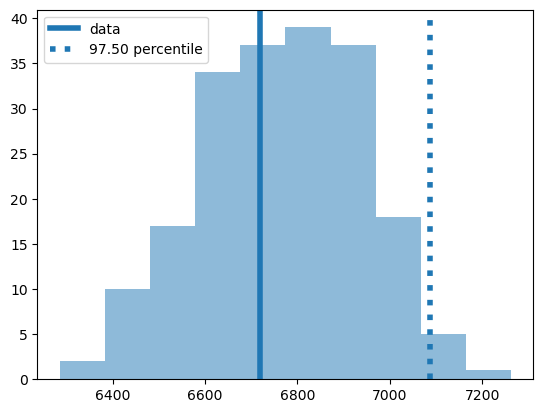

In [277]:
ph.plot_shuffle_data_dist_with_thresh(c_l,c_data,alpha=0.025,fig=None,ax=None,lw=4)



In [13]:
task_ind =0

info_0 = central_fields_all_trialtype.loc[task_ind,0].reset_index(level=0)[['level_0',pos_key]]
info_1 = central_fields_all_trialtype.loc[task_ind,1].reset_index(level=0)[['level_0',pos_key]]



In [15]:
field_ind_diff=np.subtract.outer(info_0.values, info_1.values.T)[:,0,0,:]
pos_diff=np.subtract.outer(info_0.values, info_1.values.T)[:,1,1,:]

In [16]:
pos_diff_same_field = pos_diff[field_ind_diff==0]

In [17]:
field_iloc_0,field_iloc_1 = np.nonzero(field_ind_diff==0)

In [18]:
field_distance_thresh = 5
to_merge_inds_ma = np.abs(pos_diff_same_field) <= field_distance_thresh
to_merge_inds_in_0 = field_iloc_0[to_merge_inds_ma]
to_merge_inds_in_1 = field_iloc_1[to_merge_inds_ma]

In [21]:
to_merge_fields_in_0=central_fields_all_trialtype.loc[task_ind,0].iloc[to_merge_inds_in_0]
to_merge_fields_in_1=central_fields_all_trialtype.loc[task_ind,1].iloc[to_merge_inds_in_1]

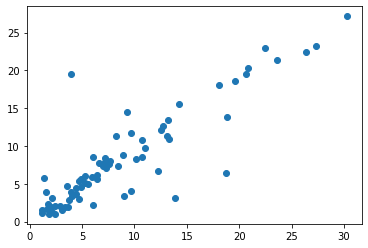

In [25]:
%matplotlib inline
plt.scatter(to_merge_fields_in_0['fr_peak'],to_merge_fields_in_1['fr_peak'])

In [27]:
fr_ratios=to_merge_fields_in_0['fr_peak']/to_merge_fields_in_1['fr_peak']

<AxesSubplot:>

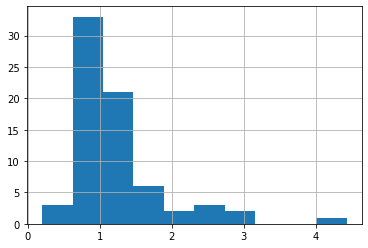

In [28]:
fr_ratios.hist()

In [ ]:
# find splitter in rate

In [32]:
left_right_similar_fields=pca.find_left_right_similar_fields(all_fields_all_trialtype.loc[task_ind])

In [34]:
index_within_to_trial_index_df

        index
0  0.0  0         1
        1         3
        2         6
        3         8
        4        10
                 ..
   1.0  32       62
        33       64
        34       66
        35       67
        36       69
Name: 0, Length: 70, dtype: int64

In [43]:
reload(pca)

<module 'process_central_arm' from '/mnt/home/szheng/projects/util_code/process_central_arm.py'>

In [38]:
fr_key = 'fr_peak'
pf_fr = pd.concat(pf_res['avg']['params'],axis=0).loc[(slice(None),slice(None),fr_key),:]
index=pf_fr.index.droplevel(2)
pf_fr.index=index
pf_fr = pf_fr.loc[task_ind]

pf_fr_trialtype_combined = pca.combine_left_right_simlar_fields(pf_fr,selected_fields=left_right_similar_fields, index_within_to_trial_index_df=index_within_to_trial_index_df.loc[task_ind])



pca.get_left_right_intensity_difference(pf_fr_trialtype_combined, index_within_to_trial_index_df.loc[task_ind])

In [801]:
field_iloc_1[to_merge_inds_ma]

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  11,  13,  15,  16,
        17,  18,  21,  22,  24,  26,  28,  29,  31,  32,  35,  37,  39,
        40,  41,  42,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        56,  60,  61,  62,  63,  65,  67,  68,  69,  70,  72,  73,  75,
        76,  77,  78,  79,  80,  81,  83,  84,  86,  87,  89,  91,  92,
        93,  94,  95,  96,  98,  99, 100, 101])

(array([48., 19.,  6.,  0.,  0.,  0.,  0.,  0.,  1.,  5.]),
 array([0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0],
       dtype=object),
 <BarContainer object of 10 artists>)

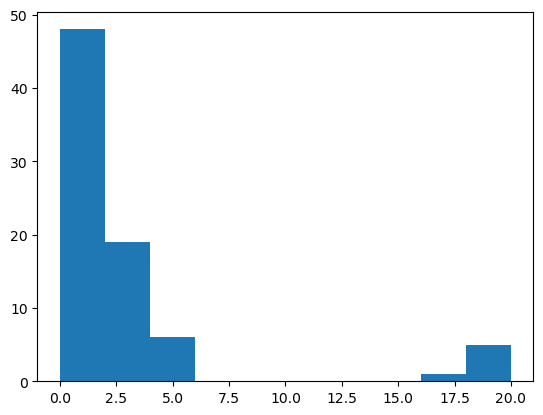

In [794]:
plt.hist(np.abs(pos_diff_same_field))

In [791]:
np.abs(pos_diff[field_ind_diff==0])

array([2, 2, 20, 1, 1, 0, 0, 0, 1, 2, 2, 20, 3, 1, 1, 0, 3, 3, 1, 0, 1, 0,
       5, 4, 1, 1, 1, 0, 0, 4, 0, 0, 4, 1, 1, 2, 2, 0, 0, 2, 2, 1, 2, 1,
       1, 3, 16, 0, 0, 0, 4, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 19, 3,
       20, 19, 2, 2, 2, 1, 0, 4, 2, 0, 0, 2, 1, 0], dtype=object)

In [776]:
np.nonzero(field_ind_diff==0)[0][17], np.nonzero(field_ind_diff==0)[1][17]

(29, 21)

In [777]:
info_0.iloc[29]

level_0    98
peak       17
Name: 0, dtype: object

In [778]:
info_1.iloc[21]

level_0    98
peak        7
Name: 0, dtype: object

In [775]:
pos_diff_same_field = pos_diff[field_ind_diff==0]
np.nonzero(pos_diff_same_field == 10)

(array([17]),)

<AxesSubplot:>

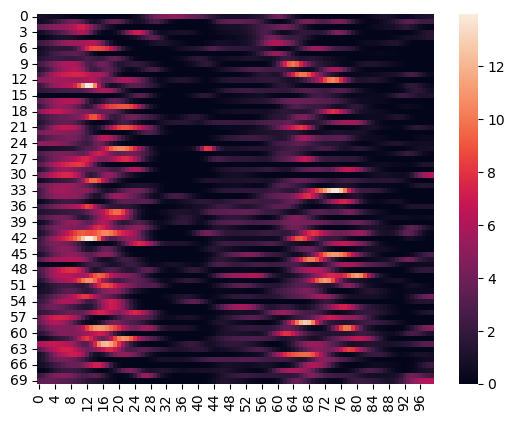

In [779]:
sns.heatmap(fr_map_concat.loc[0,98].T)

In [690]:
central_fields_all_trialtype.groupby(level=(2,3)).mean()

start   end   com  peak    fr_peak    fr_mean
    field_index                                               
27  0              1.0  30.0  15.0  15.0  27.428020  21.757817
29  0              1.0  10.0   5.0   4.0   8.114678   7.493030
    1             20.0  38.0  29.0  30.0  22.516135  14.113698
30  0              1.0  17.0   7.0   6.0   9.230598   6.729613
34  0              1.0   7.0   3.0   1.0   4.330647   3.472590
...                ...   ...   ...   ...        ...        ...
448 0             10.0  26.0  17.5  18.0  10.359990   6.603001
455 0              1.0  10.5   5.0   6.0   1.637347   1.350388
462 0             18.0  25.0  21.0  22.0   1.204894   0.929674
463 0             23.0  28.0  25.0  26.0   1.387648   1.212000
465 0             11.0  34.0  22.0  21.0   2.176381   1.154307

[144 rows x 6 columns]

In [680]:
fr_map_concat

0    1    2    3         4    5    6    7         8   \
0 1.0   0   1.100900  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        1   1.043072  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        2   0.956631  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        3   0.861780  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
        4   0.764116  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
...              ...  ...  ...  ...       ...  ...  ...  ...       ...   
  480.0 95  1.022122  0.0  0.0  0.0  0.482958  0.0  0.0  0.0  1.075058   
        96  1.282341  0.0  0.0  0.0  0.340733  0.0  0.0  0.0  0.409300   
        97  1.491263  0.0  0.0  0.0  0.209272  0.0  0.0  0.0  0.134418   
        98  1.643708  0.0  0.0  0.0  0.117377  0.0  0.0  0.0  0.037911   
        99  1.726322  0.0  0.0  0.0  0.072404  0.0  0.0  0.0  0.010921   

                  9   ...        60        61        62   63        64  \
0 1.0   0   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        1   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        2   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        3   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
        4   0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   
...              ...  ...       ...       ...       ...  ...       ...   
  480.0 95  0.020796  ...  0.000349  0.053002  0.001748  0.0  0.002523   
        96  0.003685  ...  0.000000  0.011011  0.000000  0.0  0.000000   
        97  0.000000  ...  0.000000  0.001781  0.000000  0.0  0.000000   
        98  0.000000  ...  0.000000  0.000287  0.000000  0.0  0.000000   
        99  0.000000  ...  0.000000  0.000000  0.000000  0.0  0.000000   

                  65        66        67        68        69  
0 1.0   0   0.000000  0.000000  0.000000  1.276029  0.000000  
        1   0.000000  0.000000  0.000000  1.010956  0.000000  
        2   0.000000  0.000000  0.000000  0.706983  0.000000  
        3   0.000000  0.000000  0.000000  0.500585  0.000000  
        4   0.000000  0.000000  0.000000  0.391239  0.000000  
...              ...       ...       ...       ...       ...  
  480.0 95  0.099032  0.010667  0.000109  0.001386  0.331447  
        96  0.031307  0.002283  0.000000  0.000000  0.334545  
        97  0.008732  0.000000  0.000000  0.000000  0.312716  
        98  0.002201  0.000000  0.000000  0.000000  0.284268  
        99  0.000626  0.000000  0.000000  0.000000  0.265498  

[42200 rows x 70 columns]

# confirm that cpd is not affected by trial length

In [663]:
import ruptures as rpt

n_result_l = []
n_result_long_l = []
for i in range(500):

    n_samples, n_dims, sigma = 10, 1, 2
    n_bkps = 2  # number of breakpoints
    signal, bkps = rpt.pw_constant(n_samples, n_dims, n_bkps, noise_std=sigma)
#     signal[signal<0]=0
    # signal = signal / np.max(signal,axis=0,keepdims=True)
    signal =  (signal -  np.min(signal,axis=0,keepdims=True)) / (np.max(signal,axis=0,keepdims=True) - np.min(signal,axis=0,keepdims=True))
#     signal = signal / np.max(signal,axis=0,keepdims=True)

#     signal_rep = np.repeat(signal,2,axis=0)
    signal_rep, bkps = rpt.pw_constant(n_samples*2, n_dims, n_bkps, noise_std=sigma)

    signal_rep =  (signal_rep -  np.min(signal_rep,axis=0,keepdims=True)) / (np.max(signal_rep,axis=0,keepdims=True) - np.min(signal_rep,axis=0,keepdims=True))
    
    
    model=rpt.Pelt(model="l2",min_size=1,jump=1)
    result =  model.fit_predict(signal,0.1)
    n_result_l.append(len(result))
    result_long = model.fit_predict(signal_rep,0.1)
    n_result_long_l.append(len(result_long))
    if len(result_long) > 10:
        break


(array([ 55., 303.,  82.,  43.,   0.,   8.,   7.,   0.,   1.,   1.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

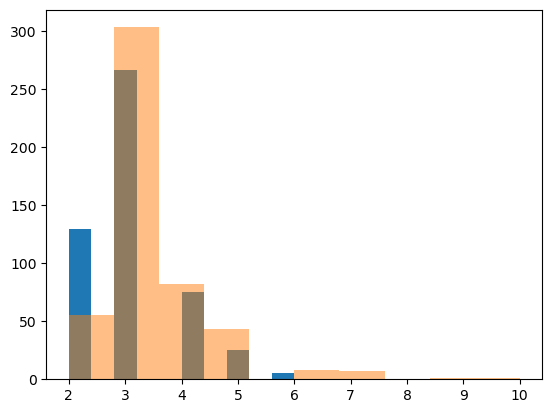

In [664]:
plt.hist(n_result_l)
plt.hist(n_result_long_l,alpha=0.5)

(<Figure size 1000x200 with 1 Axes>, [<AxesSubplot:>])

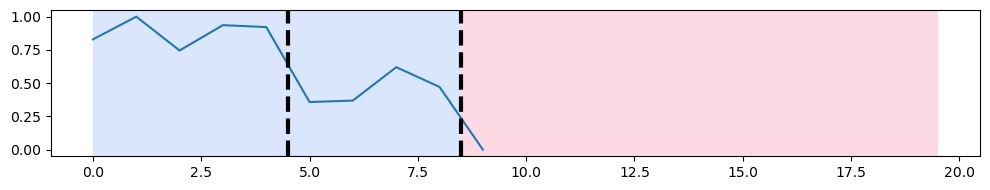

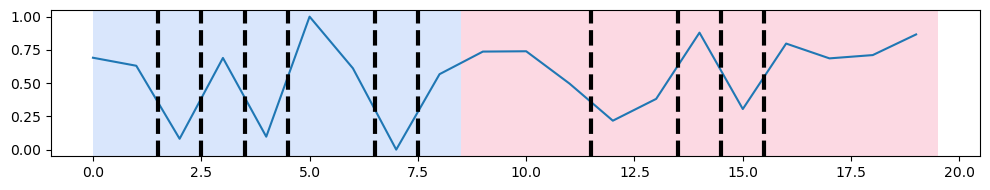

In [652]:
rpt.display(signal, bkps, result)
rpt.display(signal_rep, bkps, result_long)

# get time of place field visits per trial

In [348]:
# spk_beh_df_withtime = spk_beh_df.reset_index().rename(columns={'Time (s)':'time'})

# speed_key = 'v'
# speed_thresh = 1
# spk_beh_df_withtime = spk_beh_df_withtime.query(f'{speed_key}>@speed_thresh')

In [356]:
# trial_pos_info = spk_beh_df_withtime.groupby(['trial','lin_binned']).mean()[['time','v','task_index','visitedArm','correct']]

In [184]:
# task_ind,tt_ind = 0,0

In [17]:
changes_df_onett = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3].dropna(axis=1).droplevel(level=(0,1))
changes_df_both_tt = switch_res['avg']['changes_df'].loc[task_ind,slice(None),0.3,'switch_magnitude',0.4]


/tmp/ipykernel_226622/1878926535.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df_onett = switch_res['avg']['changes_df'].loc[task_ind,tt_ind,0.3].dropna(axis=1).droplevel(level=(0,1))


In [165]:
# all_fields_onett = pf_res['avg']['all_fields'][task_ind,tt_ind]

In [ ]:
# index_within_to_trial_index_df = dpp.index_within_to_trial_index(spk_beh_df)

In [487]:
# # pos_key = 'peak'
# all_sw_times_v = []
# for trial_within in changes_df_onett.columns:
#     trial_index = index_within_to_trial_index_df.loc[task_ind,tt_ind].loc[trial_within]
#     sw = changes_df_onett.loc[:,trial_within] !=0
#     sw_fields = changes_df_onett.index[sw.to_numpy().nonzero()[0]]
# #     sw_fields_pos = all_fields_onett[pos_key].loc[sw_fields]
#     sw_fields_pos = field_loc[trial_within].loc[sw_fields]
#     sw_sign = changes_df_onett.loc[:,trial_within].loc[sw]
#     interp_func_res = pos_to_time_func_per_trial[trial_index](sw_fields_pos.values.astype(float))
#     interp_func_res = pd.DataFrame(interp_func_res,index=sw_fields,columns=['time','v'])
#     interp_func_res['sign'] = sw_sign
    
#     if interp_func_res.shape[0]>0:
# #         interp_func_res.index.name = ('uid','field_index')
#         interp_func_res['field_pos'] = sw_fields_pos
#         interp_func_res = interp_func_res.reset_index().rename(columns={'level_0':'uid','level_1':'field_index'})
#         interp_func_res['index_within_trialtype'] = trial_within
#         interp_func_res['trial_index'] = trial_index
        

#         all_sw_times_v.append(interp_func_res)
# all_sw_times_v = pd.concat(all_sw_times_v,axis=0)
# all_sw_times_v['task_ind'] =task_ind
# all_sw_times_v['trial_type_ind'] = tt_ind

In [164]:
from scipy.interpolate import interp1d
def get_trial_pos_info(spk_beh_df,speed_key = 'v',speed_thresh = 1,n_lin_bins=100):
    '''
    get the look up table for some beh_var at eac trial & pos
    
    trial_pos_info: df: (trial, lin_binned) x [time, v, task_index, visitedArm, correct]
    '''
    if 'lin_binned' not in spk_beh_df.columns:
        spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=n_lin_bins)
    spk_beh_df_withtime = spk_beh_df.reset_index().rename(columns={'Time (s)':'time'})
    spk_beh_df_withtime = spk_beh_df_withtime.query(f'{speed_key}>@speed_thresh')
    trial_pos_info = spk_beh_df_withtime.groupby(['trial','lin_binned']).mean()[['time','v','task_index','visitedArm','correct']]
    return trial_pos_info

def get_field_loc_per_trial(pf_res, task_ind,tt_ind):
    '''
    just a wrapper for convenience; content might subject to change
    
    field_loc: nfields x ntrials_within_one_tt
    '''
    field_loc = pf_res['avg']['params'][task_ind,tt_ind].loc['com']
    field_loc=field_loc.interpolate(method='linear',axis=1) # interpolate to get rid of the nan
    return field_loc

def get_all_switch_times(trial_pos_info,field_loc,changes_df_onett,index_within_to_trial_index_df,task_ind=0,tt_ind=0):
    '''
    trial_pos_info, from get_trial_pos_info
    field_loc, from get_field_loc_per_trial
    changes_df_onett, nfields x ntrials_within
    index_within_to_trial_index_df, from dpp.index_within_to_trial_index
    '''
    all_sw_times_v = []
    for trial_within in changes_df_onett.columns:
        trial_index = index_within_to_trial_index_df.loc[task_ind,tt_ind].loc[trial_within]
        sw = changes_df_onett.loc[:,trial_within] !=0
        sw_fields = changes_df_onett.index[sw.to_numpy().nonzero()[0]]
    #     sw_fields_pos = all_fields_onett[pos_key].loc[sw_fields]
        sw_fields_pos = field_loc[trial_within].loc[sw_fields]
        interp_func_res = pos_to_time_func_per_trial[trial_index](sw_fields_pos.values.astype(float))
        interp_func_res = pd.DataFrame(interp_func_res,index=sw_fields,columns=['time','v'])

        if interp_func_res.shape[0]>0:
    #         interp_func_res.index.name = ('uid','field_index')
            interp_func_res['field_pos'] = sw_fields_pos
            interp_func_res = interp_func_res.reset_index().rename(columns={'level_0':'uid','level_1':'field_index'})
            interp_func_res['index_within_trialtype'] = trial_within
            interp_func_res['trial_index'] = trial_index

            all_sw_times_v.append(interp_func_res)
    all_sw_times_v = pd.concat(all_sw_times_v,axis=0)
    all_sw_times_v['task_ind'] =task_ind
    all_sw_times_v['trial_type_ind'] = tt_ind
    
    return all_sw_times_v

In [170]:
def get_pos_to_time_func_per_trial(trial_pos_info):
    '''
    trial_pos_info: from get_trial_pos_info
    ===
    pos_to_time_func_per_trial:{trial: func (pos -> time and v)}
    
    '''
    pos_to_time_func_per_trial = {}
    for trial, val in trial_pos_info.groupby(level=0):
        pos_to_time_func_per_trial[trial] = interp1d(val.loc[trial].index,val[['time','v']].T)
    return pos_to_time_func_per_trial

In [223]:
reload(pca)

<module 'process_central_arm' from '/mnt/home/szheng/projects/util_code/process_central_arm.py'>

In [226]:
all_sw_times_d[0]

,uid,field_index,time,v,field_pos,index_within_trialtype,trial_index,task_ind,trial_type_ind
0,168,0,7943.998900,43.382136,24.0,1,3,0,0
1,182,0,7943.615467,20.866055,14.0,1,3,0,0
2,200,2,7943.998900,43.382136,24.0,1,3,0,0
3,240,2,7958.002433,28.716088,81.0,1,3,0,0
4,255,0,7958.102467,28.880103,82.0,1,3,0,0
...,...,...,...,...,...,...,...,...,...
8,284,1,9970.460733,2.366357,87.0,32,68,0,0
9,293,1,9968.626933,17.623555,83.0,32,68,0,0
10,362,0,9946.454667,19.840369,14.0,32,68,0,0
11,448,1,9968.443567,7.745770,79.0,32,68,0,0


In [195]:
all_fields_all_trialtype.loc[0,0,265]

,start,end,com,peak,fr_peak,fr_mean
field_index,,,,,,
0,1,12,5,1,7.064418,5.256784


In [204]:
pf_res['avg']['params'][0,0].loc['peak'].loc[265]

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,1.0,1.0,1.0,6.0,7.0,2.0,1.0,5.0,1.0,...,2.0,3.0,3.0,1.0,6.0,5.0,6.0,1.0,4.0,6.0


In [191]:
trial_pos_info.loc[3]

,time,v,task_index,visitedArm,correct
lin_binned,,,,,
3,7940.081233,1.289525,0.0,0.0,1.0
4,7940.331300,2.580813,0.0,0.0,1.0
5,7940.954793,2.947431,0.0,0.0,1.0
6,7941.349266,3.759277,0.0,0.0,1.0
7,7943.165350,3.598111,0.0,0.0,1.0
...,...,...,...,...,...
88,7958.802633,23.303085,0.0,0.0,1.0
89,7958.885989,23.661241,0.0,0.0,1.0
90,7958.969333,24.344071,0.0,0.0,1.0


In [503]:
all_sw_times_d[0]

,uid,field_index,time,v,field_pos,index_within_trialtype,trial_index,task_ind,trial_type_ind
0,168,0,7943.936449,40.164802,22.627455,1,3,0,0
1,182,0,7943.652721,23.250370,15.117629,1,3,0,0
2,200,2,7944.054984,45.732755,25.182511,1,3,0,0
3,240,2,7957.930946,28.121121,80.142384,1,3,0,0
4,255,0,7958.068166,28.788054,81.657164,1,3,0,0
...,...,...,...,...,...,...,...,...,...
8,284,1,9974.030667,1.227755,88.142048,32,68,0,0
9,293,1,9970.736317,2.838580,87.101982,32,68,0,0
10,362,0,9946.623306,32.043087,19.058127,32,68,0,0
11,448,1,9966.952620,21.918324,72.391500,32,68,0,0


In [430]:
sw_times_all =  all_sw_times_v['time'].values


sw_times_all_diff = sw_times_all[:,None] - sw_times_all[None,:]

diff_triu = sw_times_all_diff[np.triu_indices_from(sw_times_all_diff,k=1)]
plt.hist(np.abs(diff_triu),bins=20,cumulative=True,density=True)

In [388]:
trial_pos_info.loc[trial_index].index

Int64Index([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
            37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
            54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
            71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
            88, 89, 90, 91, 92],
           dtype='int64', name='lin_binned')

In [224]:
trial_pos_info.loc[list(zip(all_change_coordinates[1].values,all_change_coordinates[0].values))]

KeyError: '[(65, 85), (18, 33), (68, 89)] not in index'

In [248]:
trial_pos_info.loc[65].loc[87]

time          9885.53930
v               15.41356
task_index       0.00000
visitedArm       0.00000
correct          1.00000
Name: 87, dtype: float64

<AxesSubplot:xlabel='Time (s)'>

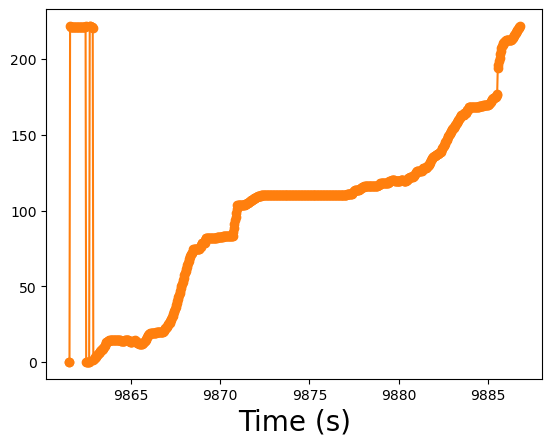

In [256]:
spk_beh_df.query('trial==65')['lin'].plot(marker='o',c='C1')

In [218]:
trial_pos_info.loc[[(0,0),(1,0)]]

,,time,v,task_index,visitedArm,correct
trial,lin_binned,,,,,
0.0,0,7865.612433,NaN,0.0,1.0,NaN
1.0,0,7888.401533,NaN,0.0,0.0,1.0


In [206]:
trial_pos_info.loc[all_change_coordinates[1].values,all_change_coordinates[0].values]

KeyError: "None of [Int64Index([32,  5,  8,  8, 80,  3,  3, 22, 22, 84,\n            ...\n            52, 52, 52, 22, 22, 22, 22, 33, 33, 81],\n           dtype='int64', length=411)] are in the [columns]"

In [197]:
all_change_coordinates[0]

     field_index
3    0              32
29   0               4
30   0               6
     0               6
31   0              81
                    ..
465  0              21
     0              21
475  0              36
476  0              29
480  0              82
Name: peak, Length: 411, dtype: object

In [192]:
field_inds[xx]

MultiIndex([(  3, 0),
            ( 29, 0),
            ( 30, 0),
            ( 30, 0),
            ( 31, 0),
            ( 34, 0),
            ( 35, 0),
            ( 36, 0),
            ( 36, 0),
            ( 36, 2),
            ...
            (463, 1),
            (463, 1),
            (463, 1),
            (465, 0),
            (465, 0),
            (465, 0),
            (465, 0),
            (475, 0),
            (476, 0),
            (480, 0)],
           length=411)

In [191]:
peaks.loc[field_inds[xx]]

     field_index
3    0              32
29   0               4
30   0               6
     0               6
31   0              81
                    ..
465  0              21
     0              21
475  0              36
476  0              29
480  0              82
Name: peak, Length: 411, dtype: object

In [187]:
field_inds

MultiIndex([(  3, 0),
            ( 27, 0),
            ( 29, 0),
            ( 29, 1),
            ( 29, 2),
            ( 30, 0),
            ( 31, 0),
            ( 32, 1),
            ( 33, 0),
            ( 34, 0),
            ...
            (454, 0),
            (455, 0),
            (456, 0),
            (462, 0),
            (463, 0),
            (463, 1),
            (465, 0),
            (475, 0),
            (476, 0),
            (480, 0)],
           length=386)

In [ ]:
all_change_coordinates_in_position = 

In [186]:
all_change_coordinates

(MultiIndex([(  3, 0),
             ( 29, 0),
             ( 30, 0),
             ( 30, 0),
             ( 31, 0),
             ( 34, 0),
             ( 35, 0),
             ( 36, 0),
             ( 36, 0),
             ( 36, 2),
             ...
             (463, 1),
             (463, 1),
             (463, 1),
             (465, 0),
             (465, 0),
             (465, 0),
             (465, 0),
             (475, 0),
             (476, 0),
             (480, 0)],
            length=411),
 15    33
 19    41
 11    25
 22    47
 23    49
       ..
 15    33
 16    35
 7     16
 1      3
 21    45
 Name: 0, Length: 411, dtype: int64)

In [158]:
changes_df_onett

0   1   2   3   4   5   6   7   8   9   ...  23  \
switch_magnitude 0.4 3   0   0   0   0   0   0   0   0   0   0   0  ...   0   
                     27  0   0   0   0   0   0   0   0   0   0   0  ...   0   
                     29  0   0   0   0   0   0   0   0   0   0   0  ...   0   
                         1   0   0   0   0   0   0   0   0   0   0  ...   0   
                         2   0   0   0   0   0   0   0   0   0   0  ...   0   
...                         ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..   
                     463 1   0   0   0   0   0   0   0   0   0   0  ...   0   
                     465 0   0   0   0   0   0   0   0   0   0   0  ...   0   
                     475 0   0   0   0   0   0   0   0  -1   0   0  ...   0   
                     476 0   0  -1   0   0   0   0   0   0   0   0  ...   0   
                     480 0   0   0   0   0   0   0   0   0   0   0  ...   0   

                            24  25  26  27  28  29  30  31  32  
switch_magnitude 0.4 3   0   0   0   0   0   0   0   0   0   0  
                     27  0   0   0   0   0   0   0   0   0   0  
                     29  0   0   0   0   0   0   0   0   0   0  
                         1   0   0   0   0   0   0   0   0   0  
                         2   0   0   0   0   0   0   0   0   0  
...                         ..  ..  ..  ..  ..  ..  ..  ..  ..  
                     463 1   0   0   0   0   0   0   0   0   1  
                     465 0   0   0   0   0   0   0   0   0   0  
                     475 0   0   0   0   0   0   0   0   0   0  
                     476 0   0   0   0   0   0   0   0   0   0  
                     480 0   0   0   0   0   0   0   0   0   0  

[386 rows x 33 columns]

# different cpd

In [37]:
task_ind = 0
pf_fr_all = pd.concat({trial_type:pf_res['avg']['params'][task_ind,trial_type].loc['fr_mean'] for trial_type in [0,1]},axis=0)


In [38]:
pf_fr_all

0          1          2          3          4          5   \
0 3   0   0.361854   1.660383   0.895757   0.000000   0.469987   0.000000   
  27  0  14.497671  13.804467  23.114017  20.660537  24.060318  18.031251   
  29  0   5.357048   8.640619  11.218283   9.660357   6.298226  16.213038   
      1   9.346967   7.827861  16.289806  15.501734   6.856234  12.040284   
      2   3.397325  16.521741  12.426897   7.661892   9.691956   6.869698   
...            ...        ...        ...        ...        ...        ...   
1 468 0   0.000000   0.202885   2.316181   3.014935   2.374491   2.322661   
  474 0   1.330156   0.634764   0.278320   0.741663   1.024034   0.228785   
      1   0.183123   0.375503   1.224852   1.380406   0.938143   3.126723   
  475 0  13.045131   9.665971  14.867707   5.485432   8.826378   7.901238   
  476 0  17.095498   9.856066   7.881852   3.677607   3.191247   0.520339   

                6          7          8          9   ...         27  \
0 3   0   0.000000   0.000000   0.000000   1.119021  ...   1.727334   
  27  0  23.890767  18.535940  16.360925  17.245221  ...  17.187522   
  29  0  13.361689  10.567988  11.872521   9.737256  ...   6.018258   
      1  10.954014  11.643840  12.378693  13.070888  ...  16.884102   
      2   6.792663   3.437770   5.679589  12.695125  ...  11.359280   
...            ...        ...        ...        ...  ...        ...   
1 468 0   0.000000   5.329780   3.057697   1.230979  ...   0.706454   
  474 0   0.972961   1.658964   1.865956   2.212002  ...   0.672457   
      1   1.029781   1.308785   1.276146   1.326746  ...   0.376834   
  475 0  11.615734   9.224996   8.131151   5.792391  ...   0.000000   
  476 0   8.477093   5.708796   1.317316   0.835597  ...   0.000000   

                28         29         30         31         32        33  \
0 3   0   2.000357   1.997971   1.820369   1.468752   2.298665       NaN   
  27  0  21.923872  31.692889  19.233423  23.450917  19.769685       NaN   
  29  0   1.828838   0.382512   6.139012   0.095607   0.458614       NaN   
      1  11.851607  15.581193  11.995440  13.127372  14.444362       NaN   
      2   6.171581   6.378478   7.828683   4.355117   4.434275       NaN   
...            ...        ...        ...        ...        ...       ...   
1 468 0   1.303251   1.059448   0.000000   0.000000   0.438168  1.773363   
  474 0   0.831629   2.313522   0.941818   1.866734   1.330426  1.084566   
      1   0.332809   1.462334   1.194335   1.561192   0.967205  1.775674   
  475 0   0.441011   0.540737   0.323808   0.753007   0.651505  1.047884   
  476 0   0.000000   0.000000   0.000000   0.009061   0.000000  0.000000   

               34        35        36  
0 3   0       NaN       NaN       NaN  
  27  0       NaN       NaN       NaN  
  29  0       NaN       NaN       NaN  
      1       NaN       NaN       NaN  
      2       NaN       NaN       NaN  
...           ...       ...       ...  
1 468 0  3.917547  1.287091  0.534938  
  474 0  1.135948  0.822414  0.590065  
      1  1.085929  1.055728  1.116643  
  475 0  0.789044  0.637242  2.587161  
  476 0  0.000000  0.000000  0.000000  

[762 rows x 37 columns]

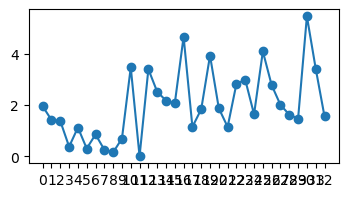

In [112]:
x1=pf_fr_all.loc[0,205,0].dropna().values[:,None]
plt.figure(figsize=(4,2))
plt.plot(x1,marker='o')
_=plt.xticks(range(x1.shape[0]))

In [113]:
pf_res['avg']['all_fields'][0,0].loc[205,0]

start            43
end              52
com              47
peak             46
fr_peak    2.749922
fr_mean    2.132579
Name: (205, 0), dtype: object

In [67]:
import ruptures as rpt
# model = rpt.Pelt(model='linear',min_size=1,jump=1)
model = rpt.Dynp(model='linear',min_size=1,jump=1)


In [52]:
x1.shape

(33, 1)

In [75]:
model.fit_predict(x1,6)

[2, 4, 6, 8, 16, 20, 33]

(<Figure size 2159.45x500 with 1 Axes>,
 array([<AxesSubplot:title={'center':'Pyramidal Cell, UID=205.0\nFR=0.76'}, xlabel='time (s)', ylabel='Linearized Position (cm)'>],
       dtype=object))

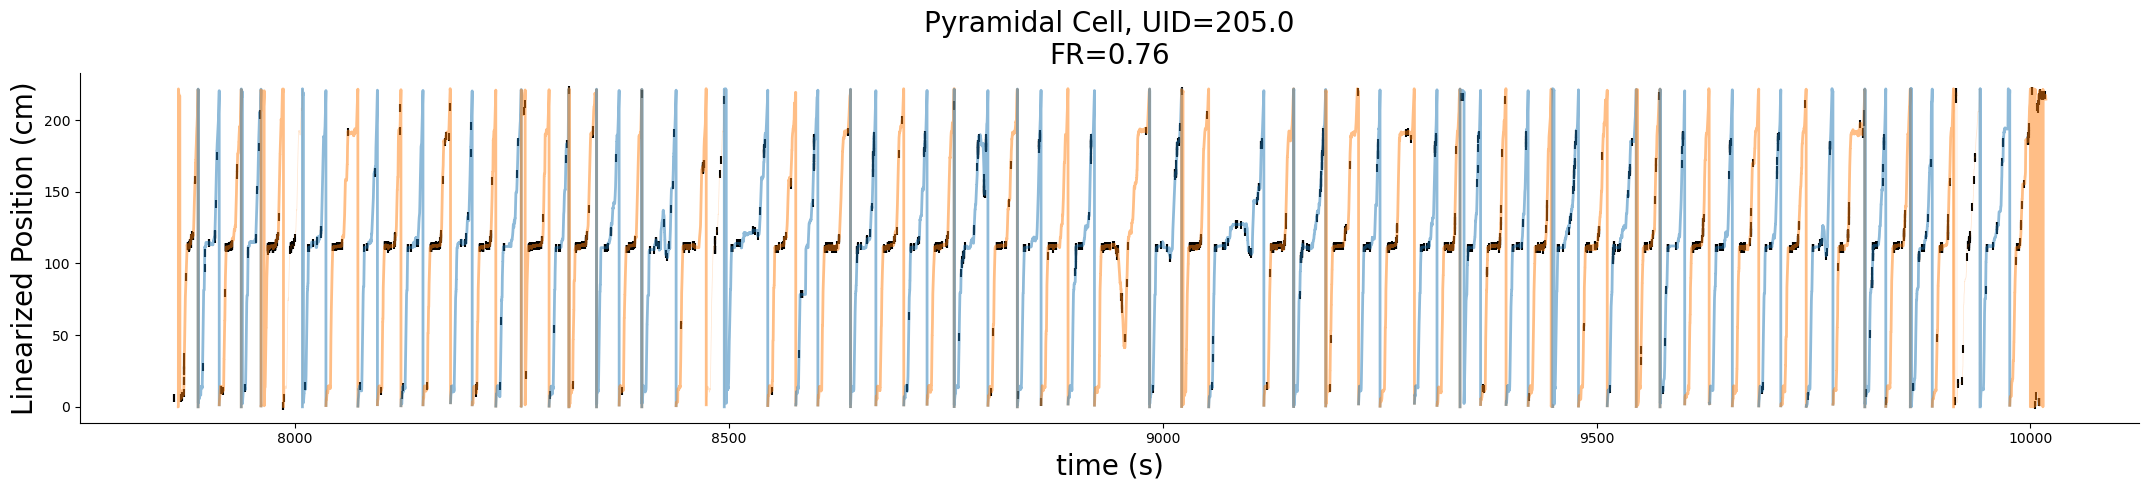

In [109]:
import plot_raster as pr
reload(pr)
pr.plot_spike_on_lin_trajectory_all_units(data_dir_full=None,cell_metrics=cell_metrics,behavior=behavior,u_ind_l=[204],
                                           dosave=False,save_dir=None,save_fn='raster1d_allunit.pdf',fig=None,axs=None
                                          )